In [1]:
import os
import torch
import pandas as pd
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

from datetime import date
# import torchvision.transforms.functional
# import torchvision.transforms.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn

from torchinfo import summary
from tqdm import tqdm

# Planet : Amazon space -- Full model running for multilabel classification

!! This is supposed to become the main jupyternotebook to run the multilabel classification and testing !!

Usefull links:
<https://learnopencv.com/multi-label-image-classification-with-pytorch-image-tagging/>

## 0) Initialization
### 0.1) Getting Module and Functions

In [2]:
from MultiModel_Amazon_Engine import *
from MultiModel_Amazon_Module import *

In [3]:
data_folder = '../IPEO_Planet_project'
if not os.path.exists(data_folder):
    data_folder = input("Enter the data folder path: ")
    assert os.path.exists(data_folder), "I did not find the folder at, "+str(data_folder)

## 1) Putting the model on the gpu

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [5]:
ground_model = GroundCNN().to(device)
cloud_model = CloudCNN().to(device)

### + Load previously trained model

In [6]:
load_models = False

the_date = date.today()
if load_models:
    print("Loading old models...")
    if not os.path.exists('ground_model_multilabel_classification.pth'):
        print('Did not find ground pretrained model file')
    if not os.path.exists('cloud_model_classification.pth'):
        print('Did not find cloud pretrained model file')
    else:
        if device=="cpu":
            ground_model.load_state_dict(torch.load(f'groundmodel_NewClassifier_{the_date}.pth', map_location=torch.device('cpu')))
            cloud_model.load_state_dict(torch.load(f'cloudmodel_NewClassifier_{the_date}.pth', map_location=torch.device('cpu')))
        else:
            ground_model.load_state_dict(torch.load('groundmodel_multilabel_classification.pth'))
            cloud_model.load_state_dict(torch.load('cloudmodel_classifier.pth'))

In [7]:
summary(ground_model, input_size=(48,3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
GroundCNN                                [48, 14]                  --
├─BatchNorm2d: 1-1                       [48, 3, 256, 256]         6
├─Conv2d: 1-2                            [48, 60, 82, 82]          21,840
├─MaxPool2d: 1-3                         [48, 60, 40, 40]          --
├─Conv2d: 1-4                            [48, 90, 36, 36]          135,090
├─AvgPool2d: 1-5                         [48, 90, 17, 17]          --
├─Conv2d: 1-6                            [48, 260, 13, 13]         585,260
├─MaxPool2d: 1-7                         [48, 260, 6, 6]           --
├─Linear: 1-8                            [48, 80]                  748,880
├─Dropout: 1-9                           [48, 80]                  --
├─Linear: 1-10                           [48, 14]                  1,134
Total params: 1,492,210
Trainable params: 1,492,210
Non-trainable params: 0
Total mult-adds (G): 20.24
Input size (MB): 37.75
Forward/

In [8]:
summary(cloud_model, input_size=(48,3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
CloudCNN                                 [48, 3]                   --
├─BatchNorm2d: 1-1                       [48, 3, 256, 256]         6
├─Conv2d: 1-2                            [48, 10, 82, 82]          3,640
├─MaxPool2d: 1-3                         [48, 10, 40, 40]          --
├─Conv2d: 1-4                            [48, 30, 36, 36]          7,530
├─AvgPool2d: 1-5                         [48, 30, 17, 17]          --
├─Conv2d: 1-6                            [48, 90, 13, 13]          67,590
├─MaxPool2d: 1-7                         [48, 90, 6, 6]            --
├─Linear: 1-8                            [48, 90]                  291,690
├─Dropout: 1-9                           [48, 90]                  --
├─Linear: 1-10                           [48, 3]                   273
├─Softmax: 1-11                          [48, 3]                   --
Total params: 370,729
Trainable params: 370,729
Non-trainable params: 

## 2) Getting the different datasets

In [9]:
train_csv = 'training.csv'
validation_csv = 'validation.csv'
test_csv = 'test.csv'

In [10]:
#Transform_choice = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(256), 
#                                       transforms.RandomAutocontrast(p=1), AdjustSaturation(1.2)])

Transform_choice = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(256),
                                       transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5)])

#Transform_choice = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(256)])

In [11]:
train_dataset = AmazonSpaceDual(csv_file=train_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)
validation_dataset = AmazonSpaceDual(csv_file=validation_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)
test_dataset = AmazonSpaceDual(csv_file=test_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)

## 3) Wrapping into the different dataloaders

In [12]:
batch_size = 24
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,  num_workers=6, shuffle=True, drop_last = True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=6, shuffle=True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=6, shuffle=True, drop_last=True)

## 4) Choice of Criterion and Opitimizer

In [13]:
learning_rate = 0.001

ground_crit = nn.BCEWithLogitsLoss()
cloud_crit = nn.BCELoss()

#ground_optim = torch.optim.Adam(ground_model.parameters(), lr=learning_rate)
ground_optim = torch.optim.SGD(ground_model.parameters(), lr=learning_rate, momentum=0.9)
#cloud_optim = torch.optim.Adam(cloud_model.parameters(), lr=learning_rate)
cloud_optim = torch.optim.SGD(cloud_model.parameters(), lr=learning_rate, momentum=0.9)

## 5) TRAINING

### A) Training the cloud model

Training on epoch 0............
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Training a cloud model


0it [00:00, ?it/s]

torch.Size([24, 3, 256, 256])
(24, 3) torch.Size([24, 3])
Cloud metrics : 0.4166666666666667 and loss:0.6023220419883728


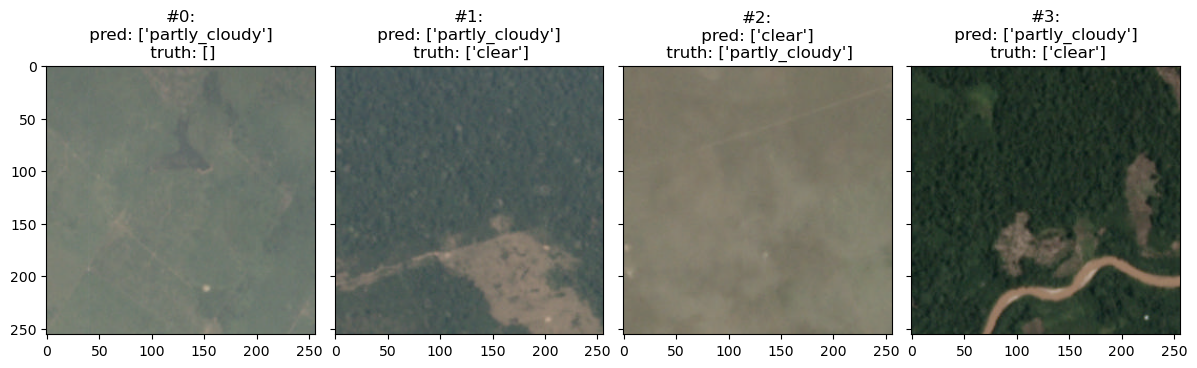

506it [00:27, 26.16it/s]

Cloud metrics : acc: 0.7916666666666666 and loss:0.32831063866615295


999it [00:49, 19.73it/s]

Cloud metrics : acc: 0.75 and loss:0.2686045169830322


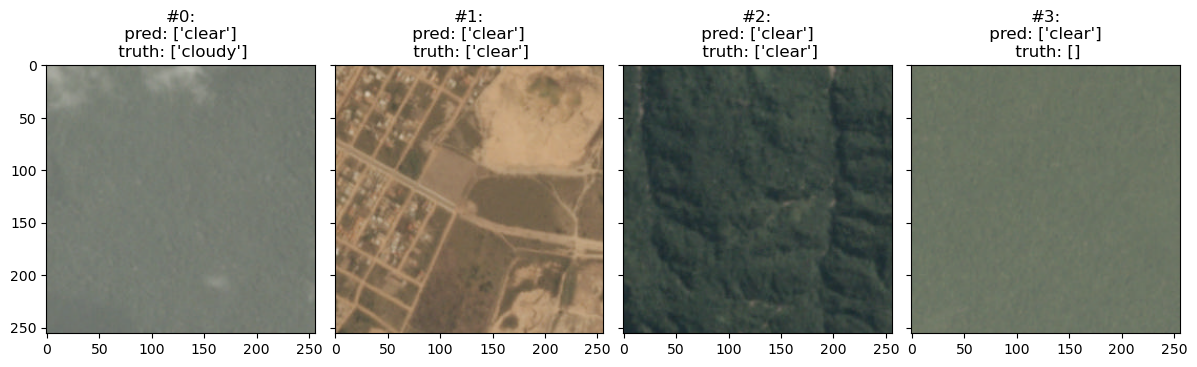

1001it [00:51, 19.57it/s]


Validating cloud model


335it [00:17, 18.71it/s]


Saved PyTorch Model State to cloudmodel_NewClassifier_15epochs_2023-01-13.pth
Training on epoch 1............
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Training a cloud model


0it [00:00, ?it/s]

torch.Size([24, 3, 256, 256])
(24, 3) torch.Size([24, 3])
Cloud metrics : 0.75 and loss:0.30818480253219604


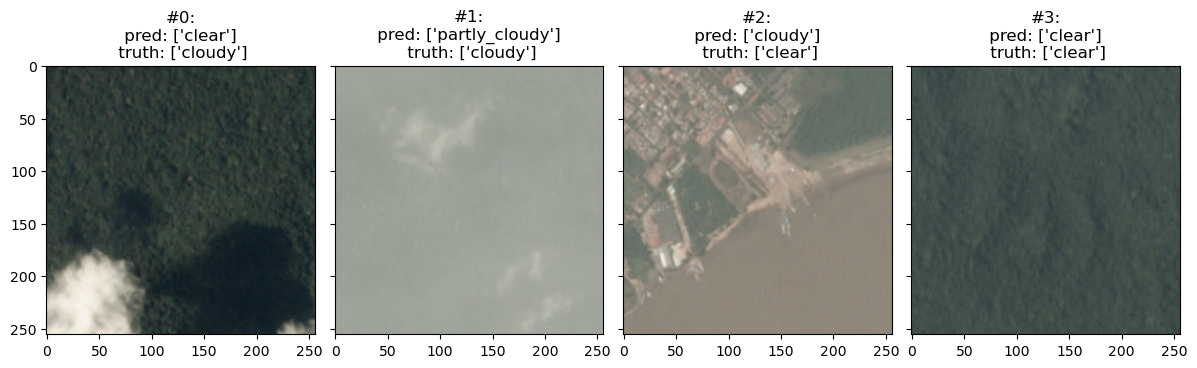

505it [00:19, 25.89it/s]

Cloud metrics : acc: 0.8333333333333334 and loss:0.21154290437698364


998it [00:38, 29.18it/s]

Cloud metrics : acc: 0.9166666666666666 and loss:0.19020108878612518


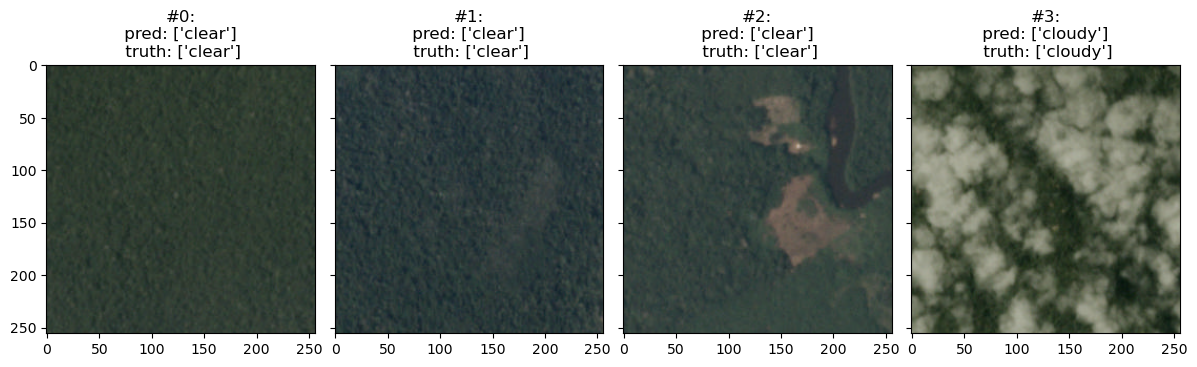

1001it [00:40, 24.51it/s]


Validating cloud model


335it [00:13, 25.53it/s]


Saved PyTorch Model State to cloudmodel_NewClassifier_15epochs_2023-01-13.pth
Training on epoch 2............
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Training a cloud model


0it [00:00, ?it/s]

torch.Size([24, 3, 256, 256])
(24, 3) torch.Size([24, 3])
Cloud metrics : 0.9583333333333334 and loss:0.14520414173603058


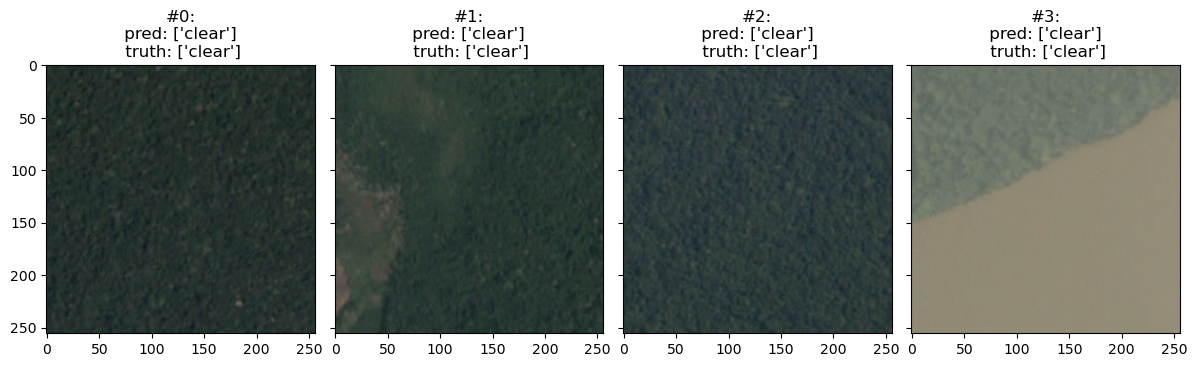

505it [00:19, 25.46it/s]

Cloud metrics : acc: 0.7083333333333334 and loss:0.2782970666885376


999it [00:38, 29.67it/s]

Cloud metrics : acc: 0.9166666666666666 and loss:0.10875391960144043


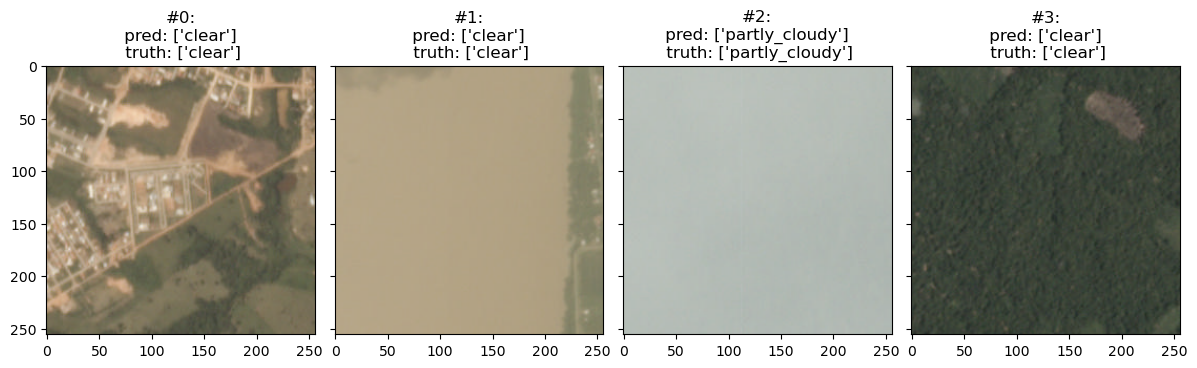

1001it [00:40, 24.81it/s]


Validating cloud model


335it [00:13, 25.39it/s]


Saved PyTorch Model State to cloudmodel_NewClassifier_15epochs_2023-01-13.pth
Training on epoch 3............
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Training a cloud model


0it [00:00, ?it/s]

torch.Size([24, 3, 256, 256])
(24, 3) torch.Size([24, 3])
Cloud metrics : 0.7916666666666666 and loss:0.23185992240905762


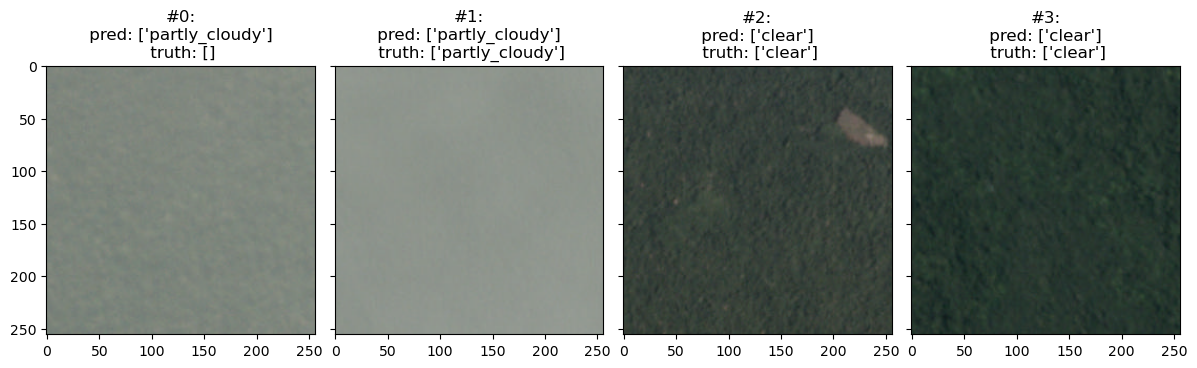

506it [00:19, 25.51it/s]

Cloud metrics : acc: 0.875 and loss:0.18408359587192535


1000it [00:39, 29.25it/s]

Cloud metrics : acc: 0.7916666666666666 and loss:0.22813759744167328


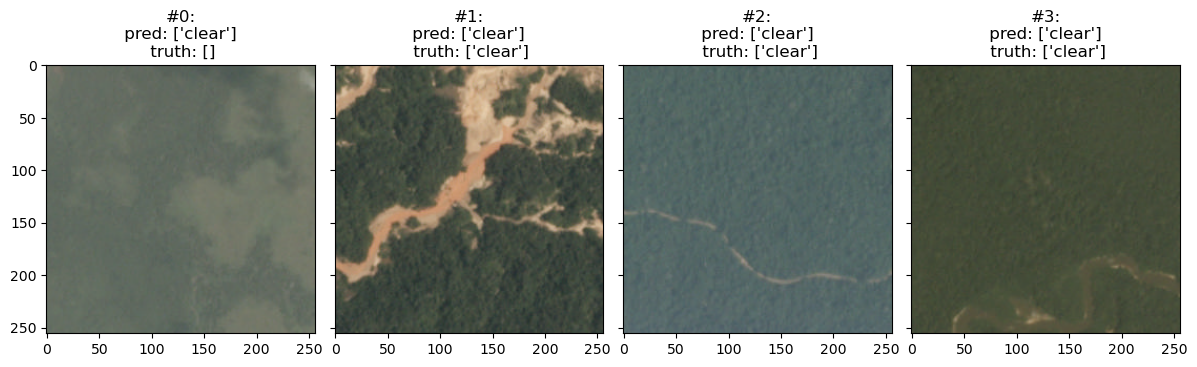

1001it [00:41, 24.33it/s]


Validating cloud model


335it [00:13, 24.60it/s]


Training on epoch 4............
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Training a cloud model


0it [00:00, ?it/s]

torch.Size([24, 3, 256, 256])
(24, 3) torch.Size([24, 3])
Cloud metrics : 0.9166666666666666 and loss:0.18732339143753052


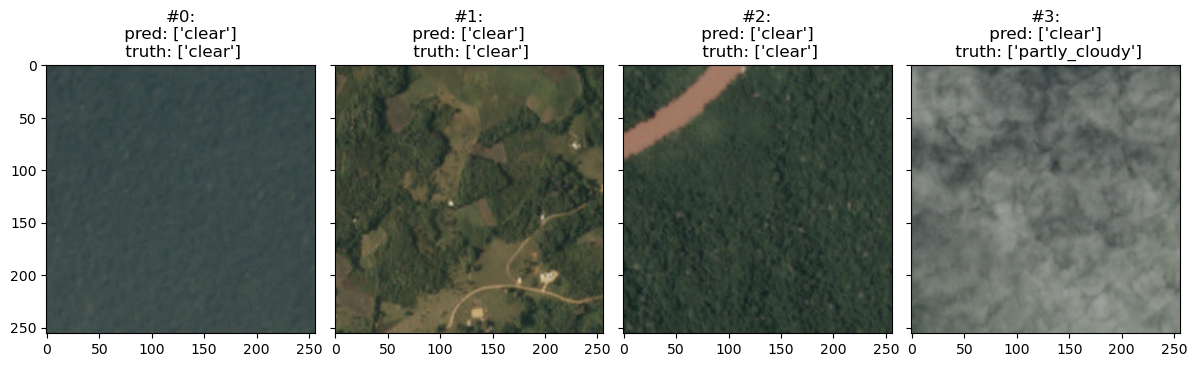

505it [00:20, 29.15it/s]

Cloud metrics : acc: 0.8333333333333334 and loss:0.33342602849006653


997it [00:38, 28.73it/s]

Cloud metrics : acc: 1.0 and loss:0.09563513845205307


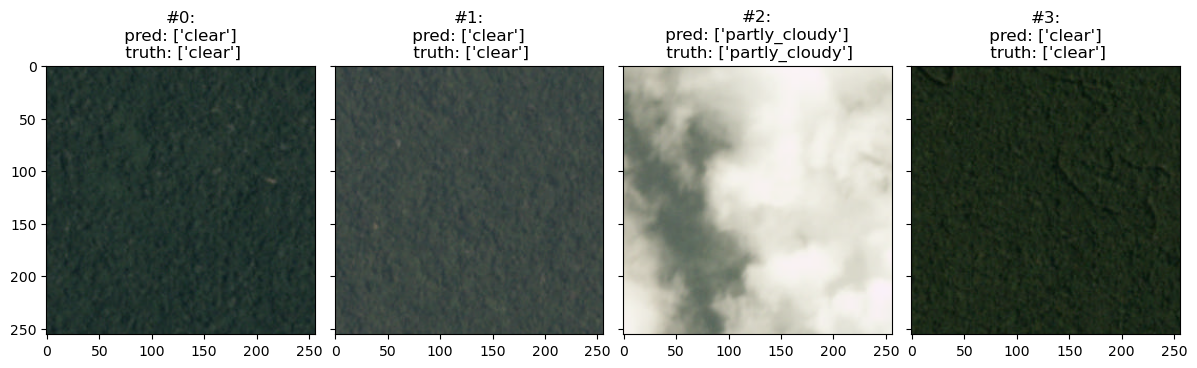

1001it [00:40, 24.92it/s]


Validating cloud model


In [ ]:
epochs_number = 15

Cloud_results = train_solo("cloud_model",cloud_model, train_dataloader, validation_dataloader, device=device,optimizer=cloud_optim, lr = learning_rate, epochs=epochs_number, loss_fn=cloud_crit)

In [ ]:
plt.style.use('ggplot')
from datetime import date

In [ ]:
plt.figure()
plt.plot(np.array(Cloud_results['training']['total_loss']), label = 'training')
plt.plot(np.array(Cloud_results['validating']['total_loss']), label = 'validation')
plt.title('Training: measured loss evolution')
plt.legend()
plt.xlabel('epoch')
plt.xticks(range(len(Cloud_results['training']['total_loss'])))
plt.savefig(f"LossEvolution_CloudModelTraining_{batch_size}batchsize_{str(learning_rate).replace('.','_')}lr_{cloud_crit}_{str(cloud_optim).split()[0]}_optim_{date.today()}.png")
#plt.ylim([0.3,0.4])
plt.show()

In [ ]:
plt.figure()
plt.plot(Cloud_results['training']['accuracy'])
plt.plot(Cloud_results['validating']['accuracy'])
plt.legend(['Training accuracy', 'validation accuracy'])
plt.title('Training: macro average metrics')
plt.savefig(f"MetricsEvol_CloudModelTraining_{batch_size}batchsize_{str(learning_rate).replace('.','_')}lr_{cloud_crit}_{str(cloud_optim).split()[0]}_optim_{date.today()}.png")
plt.ylim([0.6, 1])
plt.show()

### Saving cloud model training results into a Json file

In [ ]:
import json
# create json object from dictionary
js = json.dumps(Cloud_results)
# open file for writing, "w"
name = f"CloudModel_training_results_{epochs_number}epochs_{batch_size}batchsize_{learning_rate}lr_{cloud_crit}_crit_{str(cloud_optim).split()[0]}_optim_{date.today()}.json"
f = open(name, "a")

# write json object to file
f.write(js)
print(f"Saved the results (metrics) to: {name}")

# close file
f.close()

# B) Ground model

In [ ]:
epochs_number = 25

Ground_results = train_solo("ground_model",ground_model, train_dataloader, validation_dataloader, device=device,optimizer=ground_optim, lr = learning_rate, epochs=epochs_number, loss_fn=ground_crit)

### Saving ground model training results into a Json file

In [ ]:
import json

# create json object from dictionary
js = json.dumps(Ground_results)

# open file for writing, "w"
name = f"GroundModel_training_results_{epochs_number}epochs_{batch_size}batchsize_{learning_rate}lr_{ground_crit}_crit_{str(ground_optim).split()[0]}_optim_{date.today()}.json"
f = open(name,"a")

# write json object to file
f.write(js)

# close file
f.close()

## 5c) Plotting the training phases metrics

In [ ]:
import json as js

In [ ]:
load_ground_json = False

if load_ground_json:
    json_file = open("./GroundModel_training_results_10epochs_48batchsize_0.05lr_BCEWithLogitsLoss()_crit_SGD_optim_2023-01-09.json")
    if json_file:
        print("Loading results from json file...")
        Ground_results = js.load(json_file)

In [ ]:
plt.figure()
plt.plot(np.array(Ground_results['training']['total_loss']), label = 'training')
plt.plot(np.array(Ground_results['validating']['total_loss']), label = 'validation')
plt.title('Training: measured loss evolution')
plt.legend()
plt.xlabel('epoch')
plt.savefig(f"LossEvolution_GroundModelTraining_{batch_size}batchsize_{str(learning_rate).replace('.','_')}lr_{cloud_crit}_{str(cloud_optim).split()[0]}_optim_{date.today()}.png")
plt.show()

In [ ]:
plt.figure()
plt.plot(np.array(Ground_results['training']['macro/f1']))
plt.plot(np.array(Ground_results['training']['macro/precision']))
plt.plot(np.array(Ground_results['training']['macro/recall']))
plt.legend(['f1 score', 'precision score', 'recall score'])
plt.title('Ground model training: macro average metrics')
plt.xlabel('epoch')
plt.savefig(f"Metrics_GroundModelTraining_{batch_size}batchsize_{str(learning_rate).replace('.','_')}lr_{cloud_crit}_{str(cloud_optim).split()[0]}_optim_{date.today()}.png")
plt.show()

In [ ]:
plt.figure()
plt.plot(np.array(Ground_results['training']['hamming_loss']), label='Training')
plt.plot(np.array(Ground_results['validating']['hamming_loss']), label='Validation')
plt.legend()
plt.title('Average Hamming distance')
plt.xlabel('epoch')
plt.show()

# 6) TESTING

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, hamming_loss, f1_score, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay

#

In [ ]:
criterion=nn.BCEWithLogitsLoss()
tags_ground = ['haze', 'primary', 'agriculture', 'water', 'habitation', 'road', 'cultivation', 'slash_burn',
         'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
        'selective_logging', 'blow_down']
target_ground = "ground_target"

In [ ]:
testing_results = testing_multi(test_dataloader, ground_model, cloud_model, device = device, 
                  criterion_gr=nn.BCEWithLogitsLoss(), criterion_cl =nn.BCELoss())

### Ground Model

In [ ]:
report_ground = classification_report(y_true=testing_results['ground']['target'], 
                                      y_pred=testing_results['ground']['predicted'],
                                      target_names = test_dataloader.dataset.tags_ground.keys(),
                                      output_dict=True, zero_division=0)


plt.figure(figsize = (7,5), dpi = 120)
sns.heatmap(pd.DataFrame(report_ground).iloc[:-1, :-4].T, annot=True, cmap="PiYG")
plt.savefig("./ground_testing")

plt.figure()
sns.heatmap(pd.DataFrame(report_ground).iloc[:-1, -4:].T, annot=True, cmap="PiYG")

plt.figure()
sns.heatmap(pd.DataFrame(report_ground).iloc[-1:, :].T, annot=True, cmap="PiYG")
plt.xlabel('the number of actual occurrences of the class in the dataset')

### Cloud Model

In [ ]:
report_cloud = classification_report(y_true=testing_results['cloud']['target'], 
                                      y_pred=testing_results['cloud']['predicted'],
                                      target_names = test_dataloader.dataset.tags_cloud.keys(),
                                      output_dict=True, zero_division=0)

plt.figure()
sns.heatmap(pd.DataFrame(report_cloud).iloc[:-1, :-4].T, annot=True, cmap="PiYG")

plt.figure()
sns.heatmap(pd.DataFrame(report_cloud).iloc[:-1, -4:].T, annot=True, cmap="PiYG")

plt.figure()
sns.heatmap(pd.DataFrame(report_cloud).iloc[-1:, :].T, annot=True, cmap="PiYG")
plt.xlabel('the number of actual occurrences of the class in the dataset')

### Both Models

In [ ]:
all_tags = list(test_dataloader.dataset.tags_ground.keys()) + list(test_dataloader.dataset.tags_cloud.keys())
report_total = classification_report(y_true=testing_results['total']['target'], 
                                      y_pred=testing_results['total']['predicted'],
                                      target_names = all_tags,
                                      output_dict=True, zero_division=0)

plt.figure()
sns.heatmap(pd.DataFrame(report_total).iloc[:-1, :-4].T, annot=True, cmap="PiYG")

plt.figure()
sns.heatmap(pd.DataFrame(report_total).iloc[:-1, -4:].T, annot=True, cmap="PiYG")

plt.figure()
sns.heatmap(pd.DataFrame(report_total).iloc[-1:, :].T, annot=True, cmap="PiYG")
plt.xlabel('the number of actual occurrences of the class in the dataset')